In [114]:
#! pip install yahoo_fin

In [115]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import scipy.stats as stat
import scipy
import datetime
import numpy as np
from arch.unitroot import VarianceRatio

from yahoo_fin.stock_info import *

# We will look at stock prices 
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,6,1)



stock = get_data('AAPL' , start_date = start, end_date = end)

stock.head()

stock=stock.dropna()
close = pd.DataFrame(stock["close"]).dropna()
simple_return = close.pct_change().dropna()
log_return = np.log(1+simple_return)

<AxesSubplot:>

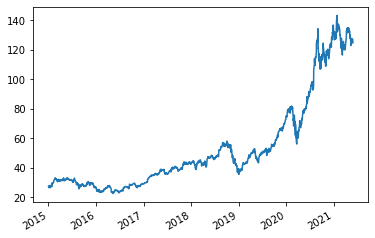

In [116]:
stock["close"].plot(grid = False) # Plot the adjusted closing price 



Populating the interactive namespace from numpy and matplotlib


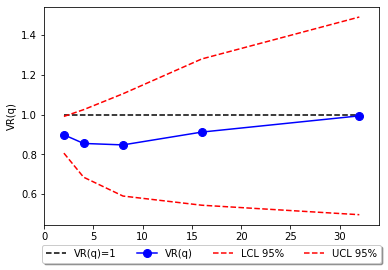

In [117]:
x = np.asarray(close)
x = np.log(x)
N=len(x)
vr_1=[]
vrt = []
w=[]
varvrt = []
zvrt = []
q = []
lcl=[]
ucl=[]
vr_1=[]
p_value=[]
stderr=[]
alpha=0.05
k=5

def VRTest():
    for ii in range (1, k+1):
        a=2**ii
        q.append(a)
        vr = VarianceRatio(x, a)
        vrt.append(vr.vr)
        se=np.sqrt(vr._stat_variance)/np.sqrt(vr._nobs-1)
        stderr.append(se)
        lower=vr.vr-stat.norm.ppf(1-alpha/2)*se
        upper=vr.vr+stat.norm.ppf(1-alpha/2)*se
        one=1
        zvrt.append(vr.stat)
        lcl.append(lower)
        ucl.append(upper)
        vr_1.append(one)
        p_value.append(vr.pvalue)

    return vrt,p_value,zvrt,q,stderr 
VRTest()

confidence=1-alpha
%pylab inline
#pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
#plt.ylim(min(lcl), max(ucl))
plt.xlim(0, 2**k+2)
plt.xlabel( 'q' )
plt.ylabel( 'VR(q)' )
plt.plot(q, vr_1,color='black', linestyle='dashed', label='VR(q)=1')
plt.plot(q, vrt, color='blue', marker='o',markerfacecolor='blue', markersize=8,label='VR(q)')
plt.plot(q, lcl,color='red', linestyle='dashed', label='LCL ' +str('{:.0%}'.format(confidence)))
plt.plot(q, ucl,color='red', linestyle='dashed', label='UCL ' +str('{:.0%}'.format(confidence)))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),fancybox=True, shadow=True, ncol=5)

plt.show()

# Individual Variance Ratio Tests

In [118]:
results=pd.DataFrame(columns=['q','VR test', 'Std. Error','z statistic', 'P-value'])
results['q']=q
results['VR test']=vrt
results['Std. Error']=stderr
results['z statistic']=zvrt
results['P-value']=p_value

In [119]:
%%latex
\[\left\{ \begin{align}
  & {{H}_{0i}}:VR({{q}_{i}})=1 \\ 
 & {{H}_{Ai}}:VR({{q}_{i}})\ne 1 \\ 
\end{align} \right.\]


<IPython.core.display.Latex object>

In [120]:
results

,q,VR test,Std. Error,z statistic,P-value
0,2,0.898699,0.046999,-2.155377,0.031132
1,4,0.855315,0.086412,-1.674363,0.094059
2,8,0.847946,0.130892,-1.161668,0.245370
3,16,0.912253,0.187185,-0.468773,0.639232
4,32,0.993651,0.252964,-0.025099,0.979976


# Multiple Variance Ratio Test - Studentized Maximum Modulus

In [121]:
z=abs(results["z statistic"]).max()
alpha_star=1-(1-alpha)**(1/k)
alpha_star
z_star=stat.norm.ppf(1-alpha_star/2)
z_star

mvr=pd.DataFrame(columns=['z Statistic','Critical z','Decision'])
mvr.at[0,'z Statistic']=z
mvr['Critical z']=z_star
if z<z_star:
    mvr['Decision']="Cannot reject the null hypothesis of random walk"
else:
    mvr['Decision']="Reject the null hypothesis of random walk"
mvr

,z Statistic,Critical z,Decision
0,2.15538,2.568763,Cannot reject the null hypothesis of random walk


# Multiple Variance Ratio Test - Wald Test
Wai Mun Fong, Seng Kee Koh & Sam Ouliaris (1997) 
Joint Variance-Ratio Tests of the Martingale Hypothesis for Exchange Rates, 
Journal of Business & Economic Statistics, 15:1, 51-59, DOI: 10.1080/07350015.1997.10524686


Wald Test=$N\left[\hat{V}_{m}-l_{m}\right]^{\prime} \Phi^{-1}\left[\hat{V}_{m}-l_{m}\right] \sim \chi_{m}^{2}$

$m$ - the number of lags

$\Phi$ - covariance matrix of ${V}_{m}$

${V}_{m}$ - individual Variance Ratio statistics

$l_{m}$ is an $m \times 1$ unit vector

$\Phi=\left(\begin{array}{cc}\frac{2(2 r-1)(r-1)}{3 r} &
            \frac{2(3 s-r-1)(r-1)}{3 s} \\ \frac{2(3 s-r-1)(r-1)}{3 s}
            & \frac{2(2 s-1)(s-1)}{3 s}\end{array}\right)$, $r,s$  - lags

In [122]:
#Compute the covariance matrix
cov1=np.zeros((k,k))

q=np.asarray(q)

for i in range (0,k-1):
    for j in range (i+1,k):
        cov1[i][j]=2*(3*q[j]-q[i]-1)*(q[i]-1)/(3*q[j])
cov2=np.transpose(cov1)
cov=cov1+cov2

for i in range (0,k):
    #for j in range (i+1,k):
  
    cov[i][i]=2*(2*q[i]-1)*(q[i]-1)/(3*q[i])
    
Wald_Test=np.matmul(np.asarray(vrt)-1,np.linalg.inv(cov))
                    
Wald_Test=N*np.matmul(Wald_Test,np.transpose(np.asarray(vrt)-1))

p_val= 1-stat.chi2.cdf(Wald_Test,k)

mvrw=pd.DataFrame(columns=['Wald Test','Critical Chi2','P-value','Decision'])
mvrw.at[0,'Wald Test']=Wald_Test
mvrw['Critical Chi2']=stat.chi2.ppf(alpha/2,k)
mvrw['P-value']=p_val
if p_val>0.05:
    mvrw['Decision']="Cannot reject the null hypothesis of random walk"
else:
    mvrw['Decision']="Reject the null hypothesis of random walk"
mvrw

,Wald Test,Critical Chi2,P-value,Decision
0,18.6219,0.831212,0.00226,Reject the null hypothesis of random walk
